In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

pd.set_option('display.max_rows', 500)

In [2]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [61]:
query = '''
    SELECT
        CusipId, 
        EOMONTH(LtTrdExctnDt) AS LtTrdExctnDt, 
        RptdPr, 
        Coupon, 
        InterestFrequency, 
        FirstInterestDate, 
        NextInterestDate, 
        LatestInterestDate, 
        T, 
        D, 
        CouponsPaid, 
        AccruedInterest, 
        R
    FROM 
        BondReturns
'''

df = pd.read_sql(query, connection)
df.to_csv('data/output/bondReturns.csv', index=False)

df = pd.read_csv('data/output/bondReturns.csv')
df['LtTrdExctnDt'] = pd.to_datetime(df['LtTrdExctnDt'])

In [62]:
df.head()

,CusipId,LtTrdExctnDt,RptdPr,Coupon,InterestFrequency,FirstInterestDate,NextInterestDate,LatestInterestDate,T,D,CouponsPaid,AccruedInterest,R
0,000325AA8,2002-07-31,100.625,9.0,2,1996-02-09,2002-08-09,2002-02-09,180,167,0,2.087500,NaN
1,000336AE7,2002-08-31,97.693,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,93,0,0.904167,NaN
2,000336AE7,2002-09-30,93.155,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,123,0,1.195833,-0.046448
3,000336AE7,2002-10-31,96.000,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,153,0,1.487500,0.030543
4,000336AE7,2002-11-30,103.431,7.0,2,1998-05-27,2003-05-27,2002-11-27,180,0,1,0.000000,0.077426


In [63]:
df['R'] = df['R'].fillna(0)

In [64]:
df.head()

,CusipId,LtTrdExctnDt,RptdPr,Coupon,InterestFrequency,FirstInterestDate,NextInterestDate,LatestInterestDate,T,D,CouponsPaid,AccruedInterest,R
0,000325AA8,2002-07-31,100.625,9.0,2,1996-02-09,2002-08-09,2002-02-09,180,167,0,2.087500,0.000000
1,000336AE7,2002-08-31,97.693,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,93,0,0.904167,0.000000
2,000336AE7,2002-09-30,93.155,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,123,0,1.195833,-0.046448
3,000336AE7,2002-10-31,96.000,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,153,0,1.487500,0.030543
4,000336AE7,2002-11-30,103.431,7.0,2,1998-05-27,2003-05-27,2002-11-27,180,0,1,0.000000,0.077426


In [65]:
df['logR'] = np.log(1 + df['R'])

In [66]:
df.head()

,CusipId,LtTrdExctnDt,RptdPr,Coupon,InterestFrequency,FirstInterestDate,NextInterestDate,LatestInterestDate,T,D,CouponsPaid,AccruedInterest,R,logR
0,000325AA8,2002-07-31,100.625,9.0,2,1996-02-09,2002-08-09,2002-02-09,180,167,0,2.087500,0.000000,0.000000
1,000336AE7,2002-08-31,97.693,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,93,0,0.904167,0.000000,0.000000
2,000336AE7,2002-09-30,93.155,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,123,0,1.195833,-0.046448,-0.047562
3,000336AE7,2002-10-31,96.000,7.0,2,1998-05-27,2002-11-27,2002-05-27,180,153,0,1.487500,0.030543,0.030086
4,000336AE7,2002-11-30,103.431,7.0,2,1998-05-27,2003-05-27,2002-11-27,180,0,1,0.000000,0.077426,0.074575


In [67]:
J = 12 # formation period

df_ = df[
    ['CusipId', 'LtTrdExctnDt', 'R', 'logR']
].sort_values(['CusipId', 'LtTrdExctnDt']).set_index('LtTrdExctnDt')

cumr = df_.groupby(['CusipId'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [68]:
cumr.tail(10)

,CusipId,LtTrdExctnDt,SumLogR,CumRet
1135694,989822AA9,2022-06-30,-0.084914,-0.081408
1135695,989822AA9,2022-07-31,-0.091517,-0.087454
1135696,989822AA9,2022-08-31,-0.091165,-0.087133
1135697,989822AA9,2022-09-30,-0.092212,-0.088088
1135698,G65422AA8,2012-04-30,NaN,NaN
1135699,G65422AA8,2012-06-30,NaN,NaN
1135700,G65422AA8,2012-07-31,NaN,NaN
1135701,G65422AA8,2012-08-31,NaN,NaN
1135702,G65422AA8,2012-09-30,NaN,NaN
1135703,G65422AA8,2013-01-31,NaN,NaN


In [69]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('LtTrdExctnDt')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [70]:
cumr.head()

,CusipId,LtTrdExctnDt,SumLogR,CumRet,MomR
12,000336AE7,2004-02-29,0.091099,0.095378,8
13,000336AE7,2004-03-31,0.081713,0.085144,8
14,000336AE7,2004-04-30,0.100567,0.105798,9
15,000336AE7,2004-05-31,0.092072,0.096443,10
16,000336AE7,2004-06-30,0.012906,0.012990,8


In [71]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.147296
2    -0.055939
3    -0.034683
4    -0.020049
5    -0.007873
6     0.004236
7     0.017970
8     0.035786
9     0.065771
10    0.389580
Name: CumRet, dtype: float64

In [72]:
K = 3 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['LtTrdExctnDt']
cumr['medate'] = cumr['LtTrdExctnDt'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['CusipId', 'form_date','MomR','hdate1','hdate2']]

In [73]:
cumr.head()

,CusipId,form_date,MomR,hdate1,hdate2
12,000336AE7,2004-02-29,8,2004-03-01,2004-05-31
13,000336AE7,2004-03-31,8,2004-04-01,2004-06-30
14,000336AE7,2004-04-30,9,2004-05-01,2004-07-31
15,000336AE7,2004-05-31,10,2004-06-01,2004-08-31
16,000336AE7,2004-06-30,8,2004-07-01,2004-09-30


In [74]:
port = pd.merge(df[['CusipId', 'LtTrdExctnDt', 'R']], cumr, on=['CusipId'], how='inner')
port = port[(port['hdate1'] <= port['LtTrdExctnDt']) & (port['LtTrdExctnDt'] <= port['hdate2'])]

port = port[['CusipId','form_date', 'MomR', 'hdate1','hdate2', 'LtTrdExctnDt', 'R']]

In [75]:
port.head()

,CusipId,form_date,MomR,hdate1,hdate2,LtTrdExctnDt,R
276,000336AE7,2004-02-29,8,2004-03-01,2004-05-31,2004-03-31,-0.009343
299,000336AE7,2004-02-29,8,2004-03-01,2004-05-31,2004-04-30,-0.028299
300,000336AE7,2004-03-31,8,2004-04-01,2004-06-30,2004-04-30,-0.028299
322,000336AE7,2004-02-29,8,2004-03-01,2004-05-31,2004-05-31,0.021826
323,000336AE7,2004-03-31,8,2004-04-01,2004-06-30,2004-05-31,0.021826


In [76]:
port['LtTrdExctnDt'] = pd.to_datetime(port['LtTrdExctnDt'])

In [77]:
port.head()

,CusipId,form_date,MomR,hdate1,hdate2,LtTrdExctnDt,R
276,000336AE7,2004-02-29,8,2004-03-01,2004-05-31,2004-03-31,-0.009343
299,000336AE7,2004-02-29,8,2004-03-01,2004-05-31,2004-04-30,-0.028299
300,000336AE7,2004-03-31,8,2004-04-01,2004-06-30,2004-04-30,-0.028299
322,000336AE7,2004-02-29,8,2004-03-01,2004-05-31,2004-05-31,0.021826
323,000336AE7,2004-03-31,8,2004-04-01,2004-06-30,2004-05-31,0.021826


In [78]:
cumr_port = port.groupby(['LtTrdExctnDt','MomR', 'form_date'])['R'].mean().reset_index()

start_yr = cumr_port['LtTrdExctnDt'].dt.year.min()+2
cumr_port = cumr_port.loc[cumr_port.LtTrdExctnDt.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['LtTrdExctnDt','MomR'])

In [79]:
cumr_port.head()

,LtTrdExctnDt,MomR,form_date,R
510,2005-01-31,1,2004-10-31,0.152053
511,2005-01-31,1,2004-11-30,-0.016402
512,2005-01-31,1,2004-12-31,0.439411
513,2005-01-31,2,2004-10-31,-0.002101
514,2005-01-31,2,2004-11-30,-0.003809


In [80]:
ewret = cumr_port.groupby(['LtTrdExctnDt','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['LtTrdExctnDt','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['LtTrdExctnDt','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'LtTrdExctnDt'])

In [81]:
ewretdf.head()

,LtTrdExctnDt,MomR,ewret,ewretstd
0,2005-01-31,1,0.191687,0.230477
10,2005-02-28,1,0.000379,0.006563
20,2005-03-31,1,-0.031189,0.005234
30,2005-04-30,1,-0.030983,0.004886
40,2005-05-31,1,0.012741,0.005184


In [82]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,213.0,0.022319,0.132046
1,2,213.0,0.000189,0.026337
2,3,213.0,-0.000594,0.020156
3,4,213.0,-0.000754,0.017024
4,5,213.0,-0.000710,0.015105
5,6,213.0,-0.000728,0.014155
6,7,213.0,-0.000760,0.013606
7,8,213.0,-0.000888,0.014338
8,9,213.0,-0.000798,0.015751
9,10,213.0,0.001628,0.029727


In [83]:
ewret_t = ewretdf.pivot(index='LtTrdExctnDt', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers

In [84]:
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
LtTrdExctnDt,,,,,,,,,,,
2005-01-31,0.191687,-0.003186,-0.002871,-0.001900,-0.000934,0.002392,0.005216,0.005658,0.007715,-0.005023,-0.196711
2005-02-28,0.000379,-0.002810,-0.004157,-0.005652,-0.005875,-0.005921,-0.005289,-0.003716,-0.000408,0.011389,0.011011
2005-03-31,-0.031189,-0.011146,-0.012396,-0.014179,-0.016511,-0.019385,-0.022541,-0.027915,-0.033885,-0.034287,-0.003098
2005-04-30,-0.030983,-0.001847,0.000313,0.002047,0.003668,0.004748,0.002278,0.003752,0.005356,-0.003106,0.027877
2005-05-31,0.012741,0.002265,0.002245,0.003853,0.003886,0.005129,0.007448,0.010430,0.013914,0.010250,-0.002491


In [85]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod()-1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod()-1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod()-1

In [86]:
mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame() 
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index() 
mom_mean

,MomR,mean
0,winners,0.001628
1,losers,0.022319
2,long_short,-0.020691


In [87]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'],0.0)).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'],0.0)).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'],0.0)).to_frame().T

t_losers['MomR']='losers' 
t_winners['MomR']='winners' 
t_long_short['MomR']='long_short'

In [88]:
t_output =pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR    mean t-stat p-value
0     winners   0.16%   0.80    0.43
1      losers   2.23%   2.47    0.01
2  long_short  -2.07%  -2.29    0.02


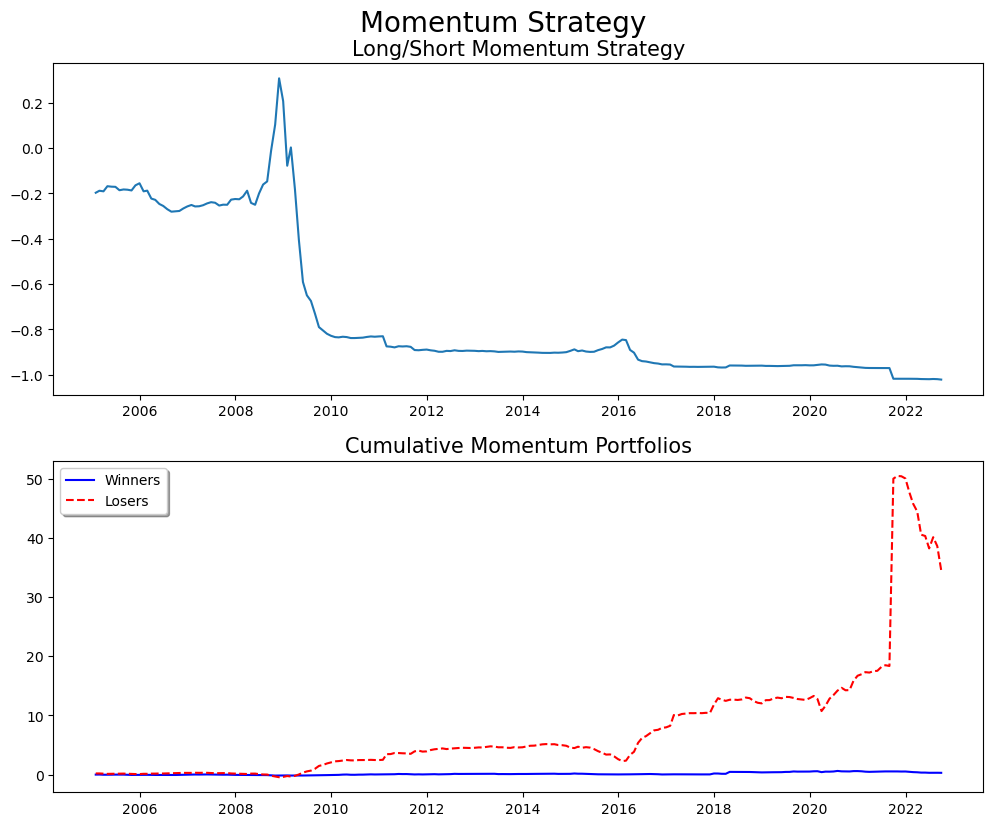

In [89]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True) 

plt.subplots_adjust(top=0.92, hspace=0.2)